# Importing Libraris

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

import joblib
from joblib import Parallel, delayed

# Loading Data

In [17]:
# Load dataset
train_df = pd.read_csv("../../data/train_with_bert_embeddings.csv")
valid_df = pd.read_csv("../../data/valid_with_bert_embeddings.csv")
test_df = pd.read_csv("../../data/test_with_bert_embeddings.csv")

# Load the pre-saved embeddings
train_embeddings = np.load("../../data/train_bert_embeddings.npy")
valid_embeddings = np.load("../../data/valid_bert_embeddings.npy")
test_embeddings = np.load("../../data/test_bert_embeddings.npy")

In [19]:
# Checking Shape of Train_df
print(train_df.shape)
print(train_df.head())

(133999, 4)
                                                text  label  \
0                    Nobody go to Walmart in sulphur      2   
1   @emberlhamon @MLidak welcome to the ugly club!!       2   
2                      getting to help coach jr high      2   
3  Yo Gotti and Black Youngsta on stage we all th...      2   
4  @spenceribarra just making sure I haven't been...      2   

         embedding_file  embedding_index  
0  train_embeddings.npy                0  
1  train_embeddings.npy                1  
2  train_embeddings.npy                2  
3  train_embeddings.npy                3  
4  train_embeddings.npy                4  


# Prepare Features and Labels

In [21]:
# Features
X_train = train_embeddings
y_train = train_df['label'].values

X_valid = valid_embeddings
y_valid = valid_df['label'].values

X_test = test_embeddings
y_test = test_df['label'].values

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(133999, 768)
(133999,)
(17223, 768)
(17223,)
(17063, 768)
(17063,)


# Create a Baseline Model and Evaluate

In [36]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate on the train set
y_train_pred = clf.predict(X_train)
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')  
print("Train F1 Macro:", train_f1_macro)

# Evaluate on the validation set
y_valid_pred = clf.predict(X_valid)
valid_f1_macro = f1_score(y_valid, y_valid_pred, average='macro')  
print("Validation F1 Macro:", valid_f1_macro)

# Evaluate on the test set
y_test_pred = clf.predict(X_test)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')  
print("Test F1 Macro:", test_f1_macro)

# The model overfits on the train data

Train F1 Macro: 0.9803631507990213
Validation F1 Macro: 0.30058928404900354
Test F1 Macro: 0.2991464218183951


# pre-Pruning (Hyperparameter Tuning)

In [37]:
# Using RandomGridSearch this time
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Use RandomizedSearchCV on the training set
random_search = RandomizedSearchCV(clf, param_distributions=param_grid,
                                   n_iter=20, cv=5, scoring='f1_macro',
                                   random_state=42, n_jobs=12)
random_search.fit(X_train, y_train)

print("Best Parameters from training:", random_search.best_params_)

# Evaluate on the train set
train_f1_macro = f1_score(y_train, random_search.best_estimator_.predict(X_train), average='macro')
print("Train F1 Macro:", train_f1_macro)

# Evaluate on the validation set
valid_f1_macro = f1_score(y_valid, random_search.best_estimator_.predict(X_valid), average='macro')
print("Validation F1 Macro:", valid_f1_macro)

# Evaluate on the test set
test_f1_macro = f1_score(y_test, random_search.best_estimator_.predict(X_test), average='macro')
print("Test F1 Macro:", test_f1_macro)

Best Parameters from training: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
Train F1 Macro: 0.39898199457267347
Validation F1 Macro: 0.32963359180509455
Test F1 Macro: 0.32488802165596287


# post-Pruning (cost-complexity pruning)

In [29]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

print("Number of candidate alphas:", len(ccp_alphas))
# Too much alphas to try, we'll randomly select 40 alphas

ccp_alphas = ccp_alphas[:-1]
ccp_alphas = np.maximum(ccp_alphas, 0)

# number of unique alphas
unique_alphas = np.unique(ccp_alphas)
unique_alphas = np.sort(unique_alphas)
print("Number of unique candidate alphas:", len(unique_alphas))

Number of candidate alphas: 25009
Number of unique candidate alphas: 9003


Number of candidate alphas being used: 40
Sampled alphas: [0.00000000e+00 7.41964061e-06 1.45327086e-05 2.02357213e-05
 2.45630831e-05 2.67742244e-05 2.83969769e-05 3.00800046e-05
 3.15093562e-05 3.28647688e-05 3.40798563e-05 3.51814992e-05
 3.63343706e-05 3.74144092e-05 3.87057498e-05 4.01966397e-05
 4.19423597e-05 4.40589500e-05 4.73884133e-05 5.43787612e-05
 1.22075708e-04 1.28071454e-04 1.30399421e-04 1.39564609e-04
 1.48818151e-04 1.58060369e-04 1.66461794e-04 1.74557827e-04
 1.87859278e-04 1.90287806e-04 2.22135331e-04 2.26546936e-04
 2.46118457e-04 2.77752241e-04 2.94560671e-04 4.04949838e-04
 5.29769884e-04 6.22888228e-04 9.07964838e-04 2.41981878e-03]
Alpha: 0.00000 | Train F1 Macro: 0.9804 | Validation F1 Macro: 0.3006
Alpha: 0.00001 | Train F1 Macro: 0.9795 | Validation F1 Macro: 0.3011
Alpha: 0.00001 | Train F1 Macro: 0.9000 | Validation F1 Macro: 0.2983
Alpha: 0.00002 | Train F1 Macro: 0.8637 | Validation F1 Macro: 0.3016
Alpha: 0.00002 | Train F1 Macro: 0.8363 | Validatio

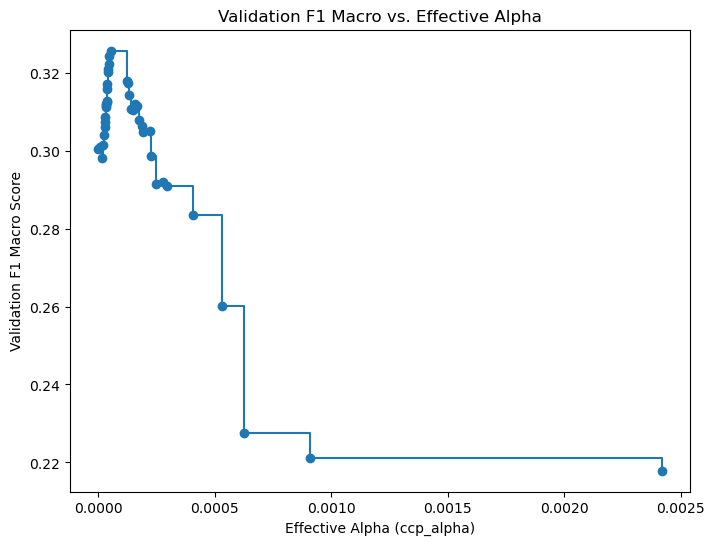

In [30]:
# The distribution of the alphas is not even, so we can't just randomly sampling it or choose with uniform step size
num_samples_last = 20  # from the last 100
num_samples_rest = 20  # from the rest of the alphas

last_100 = unique_alphas[-100:]
rest = unique_alphas[:-100]

step_last = len(last_100) // num_samples_last
sampled_last = last_100[::step_last][:num_samples_last]

step_rest = len(rest) // num_samples_rest
sampled_rest = rest[::step_rest][:num_samples_rest]

# Combine the two samples and sort them
sampled_alphas = np.sort(np.concatenate((sampled_rest, sampled_last)))
print("Number of candidate alphas being used:", len(sampled_alphas))
print("Sampled alphas:", sampled_alphas)

def train_tree(ccp_alpha):
    clf_temp = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf_temp.fit(X_train, y_train)
    return clf_temp

# Parallelize the training over candidate alphas using more cores
clfs = Parallel(n_jobs=12)(delayed(train_tree)(alpha) for alpha in sampled_alphas)

# Compute training and validation F1 macro score for each pruned tree
train_scores = [f1_score(y_train, clf_temp.predict(X_train), average='macro') for clf_temp in clfs]
valid_scores = [f1_score(y_valid, clf_temp.predict(X_valid), average='macro') for clf_temp in clfs]

# Print train and validation F1 macro score for each candidate alpha
for alpha, train_f1, valid_f1 in zip(sampled_alphas, train_scores, valid_scores):
    print(f"Alpha: {alpha:.5f} | Train F1 Macro: {train_f1:.4f} | Validation F1 Macro: {valid_f1:.4f}")

# Select the alpha that gives the highest validation accuracy
optimal_idx = np.argmax(valid_scores)
optimal_alpha = sampled_alphas[optimal_idx]
best_clf = clfs[optimal_idx]

print("\nOptimal ccp_alpha:", optimal_alpha)
print("Best Train F1 Macro with optimal alpha:", train_scores[optimal_idx])
print("Validation F1 Macro with optimal alpha:", valid_scores[optimal_idx])

# Evaluate the best pruned tree on the test set
test_f1 = f1_score(y_test, best_clf.predict(X_test), average='macro')
print("Test F1 Macro with optimal alpha:", test_f1)

# Plot validation F1 macro score vs effective alpha
plt.figure(figsize=(8, 6))
plt.plot(sampled_alphas, valid_scores, marker='o', drawstyle="steps-post")
plt.xlabel("Effective Alpha (ccp_alpha)")
plt.ylabel("Validation F1 Macro Score")
plt.title("Validation F1 Macro vs. Effective Alpha")
plt.show()

# Bagging

In [11]:
# Since the model perform very badly on test set and overfit on train set,
# we will use bagging to reduce the overfitting. I decide to try
# Random Forest and ExtraTreesClassifier

## Random Forest

In [38]:
rf = RandomForestClassifier(random_state=42, n_jobs=12)
rf.fit(X_train, y_train)

# Evaluate on the train set using F1 macro score
train_f1_rf = f1_score(y_train, rf.predict(X_train), average='macro')
valid_f1_rf = f1_score(y_valid, rf.predict(X_valid), average='macro')
test_f1_rf = f1_score(y_test, rf.predict(X_test), average='macro')

print("Random Forest Classifier:")
print("Train F1 Macro:", train_f1_rf)
print("Validation F1 Macro:", valid_f1_rf)
print("Test F1 Macro:", test_f1_rf)

Random Forest Classifier:
Train F1 Macro: 0.9803525890587028
Validation F1 Macro: 0.39177597452161317
Test F1 Macro: 0.3822561655889298


### Hyperparameter Tuning Random Forest

In [9]:
param_grid = {
    'max_depth': [20, 30, 40],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [10, 20, 30, 40, 50]
}

rf = RandomForestClassifier(random_state=42, n_jobs=13)

# Use GridSearchCV with f1_score (macro) as the scoring metric
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid,
                                      n_iter=20, cv=5, scoring='f1_macro',
                                      n_jobs=15, verbose=2, random_state=42)
random_search_rf.fit(X_train, y_train)

print("Best parameters:", random_search_rf.best_params_)
print("Best f1_macro score on training (via cross-validation):", random_search_rf.best_score_)

# Retrieve the best estimator
best_rf = random_search_rf.best_estimator_

# Evaluate training F1 macro score
train_f1 = f1_score(y_train, best_rf.predict(X_train), average='macro')
print("Train F1 Macro:", train_f1)

# Evaluate on validation and test sets using F1 macro score
valid_f1 = f1_score(y_valid, best_rf.predict(X_valid), average='macro')
test_f1 = f1_score(y_test, best_rf.predict(X_test), average='macro')

print("Validation F1 Macro:", valid_f1)
print("Test F1 Macro:", test_f1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best f1_macro score on training (via cross-validation): 0.36117332423650766
Train F1 Macro: 0.9771162244965051
Validation F1 Macro: 0.3795003142484644
Test F1 Macro: 0.37526386167109754


In [10]:
# from previous, we decided not to use so many trees for doing the hyperparameter tuning since it takes quite a long time
# because the three is rather big I have experimented with other configuration and got the result that larger number of trees generaylly
# results in better performance. 
# Let's try with the previous combination but increase the number of trees 

best_params = {
    'max_depth': 20,  
    'min_samples_split': 5,  
    'min_samples_leaf': 1,  
    'max_features': 'sqrt'  
}

# Create a new RandomForestClassifier with the best parameters
rf = RandomForestClassifier(random_state=42, n_jobs=15, **best_params)

# Try 50 and 100 trees 
for n_estimators in [50, 100, 150, 200, 300, 400, 
                     500]:
    print(f"Testing with {n_estimators} trees...")
    rf.set_params(n_estimators=n_estimators)
    rf.fit(X_train, y_train)

    # Evaluate training accuracy
    train_f1 = f1_score(y_train, rf.predict(X_train), average='macro')
    print(f"Train f1_macro with {n_estimators} trees:", train_f1)

    # Evaluate on validation and test sets
    valid_f1 = f1_score(y_valid, rf.predict(X_valid), average='macro')
    test_f1 = f1_score(y_test, rf.predict(X_test), average='macro')

    print(f"Validation f1_macro with {n_estimators} trees:", valid_f1)
    print(f"Test f1_macro with {n_estimators} trees:", test_f1)
    print("-" * 50)

Testing with 50 trees...
Train f1_macro with 50 trees: 0.9771162244965051
Validation f1_macro with 50 trees: 0.3795003142484644
Test f1_macro with 50 trees: 0.37526386167109754
--------------------------------------------------
Testing with 100 trees...
Train f1_macro with 100 trees: 0.9781728065340267
Validation f1_macro with 100 trees: 0.3955553662612075
Test f1_macro with 100 trees: 0.38601928622288767
--------------------------------------------------
Testing with 150 trees...
Train f1_macro with 150 trees: 0.9783596478133259
Validation f1_macro with 150 trees: 0.3968769519749288
Test f1_macro with 150 trees: 0.38901628407645944
--------------------------------------------------
Testing with 200 trees...
Train f1_macro with 200 trees: 0.9784975452204019
Validation f1_macro with 200 trees: 0.39611296414514297
Test f1_macro with 200 trees: 0.3914977040699569
--------------------------------------------------
Testing with 300 trees...
Train f1_macro with 300 trees: 0.9786919284991891


## Extra Trees Classifier

In [31]:
et = ExtraTreesClassifier(random_state=42, n_jobs=12)
et.fit(X_train, y_train)

train_f1_et = f1_score(y_train, et.predict(X_train), average='macro')
valid_f1_et = f1_score(y_valid, et.predict(X_valid), average='macro')
test_f1_et = f1_score(y_test, et.predict(X_test), average='macro')

print("\nExtra Trees Classifier:")
print("Train F1:", train_f1_et)
print("Validation F1:", valid_f1_et)
print("Test F1:", test_f1_et)


Extra Trees Classifier:
Train F1: 0.9803631507990213
Validation F1: 0.37752078482311796
Test F1: 0.37886126163655465


### Hyperparameter Tuning Extra Trees Classifier

In [32]:
param_grid_et = {
    'max_depth': [20, 30, 40],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [10, 20, 30, 40, 50]
}

# Instantiate the ExtraTreesClassifier with all available cores
et = ExtraTreesClassifier(random_state=42, n_jobs=13)

# Use RandomizedSearchCV to sample 20 random combinations from the grid
random_search_et = RandomizedSearchCV(estimator=et, 
                                      param_distributions=param_grid_et,
                                      n_iter=20, 
                                      cv=5, 
                                      scoring='f1_macro', 
                                      n_jobs=15, 
                                      verbose=2, 
                                      random_state=42)
random_search_et.fit(X_train, y_train)

print("Best parameters for ExtraTreesClassifier:", random_search_et.best_params_)
print("Best f1_macro score on training (via CV):", random_search_et.best_score_)

# Retrieve the best estimator
best_et = random_search_et.best_estimator_

# Evaluate performance on training, validation, and test sets
train_f1_et = f1_score(y_train, best_et.predict(X_train), average='macro')
valid_f1_et = f1_score(y_valid, best_et.predict(X_valid), average='macro')
test_f1_et = f1_score(y_test, best_et.predict(X_test), average='macro')

print("\nExtraTreesClassifier Performance:")
print("Train F1:", train_f1_et)
print("Validation F1:", valid_f1_et)
print("Test F1:", test_f1_et)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for ExtraTreesClassifier: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40}
Best f1_macro score on training (via CV): 0.366883534692572

ExtraTreesClassifier Performance:
Train F1: 0.9803620012822197
Validation F1: 0.380674538091914
Test F1: 0.3779224970564577


In [25]:
# We did same thing as we did in Random Forest 
best_params_et = {
    'max_depth': 40,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': None  
}

# Create the ExtraTreesClassifier with the best parameters
et = ExtraTreesClassifier(random_state=42, n_jobs=15, **best_params_et)

# Try different n_estimators
for n_estimators in [50, 100, 150, 200, 300, 400, 500]:
    print(f"Testing with {n_estimators} trees...")
    et.set_params(n_estimators=n_estimators)
    et.fit(X_train, y_train)

    # Evaluate training F1 macro score
    train_f1_et = f1_score(y_train, et.predict(X_train), average='macro')
    print(f"Train f1_macro with {n_estimators} trees:", train_f1_et)

    # Evaluate on validation and test sets
    valid_f1_et = f1_score(y_valid, et.predict(X_valid), average='macro')
    test_f1_et = f1_score(y_test, et.predict(X_test), average='macro')

    print(f"Validation f1_macro with {n_estimators} trees:", valid_f1_et)
    print(f"Test f1_macro with {n_estimators} trees:", test_f1_et)
    print("-" * 50)


Testing with 50 trees...
Train f1_macro with 50 trees: 0.9803620012822197
Validation f1_macro with 50 trees: 0.38072867312337044
Test f1_macro with 50 trees: 0.3779224970564577
--------------------------------------------------
Testing with 100 trees...
Train f1_macro with 100 trees: 0.980361982938964
Validation f1_macro with 100 trees: 0.3912729336104591
Test f1_macro with 100 trees: 0.38561468793614784
--------------------------------------------------
Testing with 150 trees...
Train f1_macro with 150 trees: 0.9803623828080333
Validation f1_macro with 150 trees: 0.3925393989714635
Test f1_macro with 150 trees: 0.39270728864347476
--------------------------------------------------
Testing with 200 trees...
Train f1_macro with 200 trees: 0.9803626993948834
Validation f1_macro with 200 trees: 0.397937874734465
Test f1_macro with 200 trees: 0.3940872271702866
--------------------------------------------------
Testing with 300 trees...
Train f1_macro with 300 trees: 0.980363611114296
Vali

In [23]:
# We have tried:
# 1. Used base Decision Tree model
# 2. Did pre-pruning and post-pruning on base model Decision Tree
# 3. Used Baseline RandomForestClassifier
# 4. Hyperparameter-tuned Random forest automatically and manually
# 5. Used baseline model Extra Tree Classifierr
# 6. Hyperparameter-tuned Extra Tree Classifier
# After each of the above methods, we still can't get F1 macro score above 40%. But we should try to use boosting algorithm also.

# Boosting

## XGBoost

In [26]:
# Create an XGBoost model 
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate on the train set using F1 macro score
train_f1_xgb = f1_score(y_train, xgb_model.predict(X_train), average='macro')
valid_f1_xgb = f1_score(y_valid, xgb_model.predict(X_valid), average='macro')
test_f1_xgb = f1_score(y_test, xgb_model.predict(X_test), average='macro')

# Print the results
print("XGBoost Classifier:")
print("Train F1 Macro:", train_f1_xgb)
print("Validation F1 Macro:", valid_f1_xgb)
print("Test F1 Macro:", test_f1_xgb)

XGBoost Classifier:
Train F1 Macro: 0.7242639369247231
Validation F1 Macro: 0.4185626986522181
Test F1 Macro: 0.41542303776268785


### Hyperparameter Tuning XGBoost

In [ ]:
# Too expensive to run
param_grid_xgb = {
    'max_depth': [3, 5, 7, 10], 
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'n_estimators': [10, 20, 30, 40, 50], 
    'subsample': [0.7, 0.8, 0.9, 1.0], 
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], 
    'min_child_weight': [1, 3, 5], 
}

# Instantiate the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs = 15)

random_search_xgb = RandomizedSearchCV(estimator=xgb_model, 
                                       param_distributions=param_grid_xgb,
                                       n_iter=20, 
                                       cv=5, 
                                       scoring='f1_macro', 
                                       n_jobs=15, 
                                       verbose=2, 
                                       random_state=42)

# Fit the RandomizedSearchCV on the training data
random_search_xgb.fit(X_train, y_train)

# Print the best hyperparameters and F1 macro score
print("Best parameters for XGBoost:", random_search_xgb.best_params_)
print("Best f1_macro score on training (via CV):", random_search_xgb.best_score_)

# Retrieve the best estimator
best_xgb = random_search_xgb.best_estimator_

# Evaluate performance on training, validation, and test sets
train_f1_xgb = f1_score(y_train, best_xgb.predict(X_train), average='macro')
valid_f1_xgb = f1_score(y_valid, best_xgb.predict(X_valid), average='macro')
test_f1_xgb = f1_score(y_test, best_xgb.predict(X_test), average='macro')

print("\nXGBoost Performance:")
print("Train F1 Macro:", train_f1_xgb)
print("Validation F1 Macro:", valid_f1_xgb)
print("Test F1 Macro:", test_f1_xgb)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


## LightGBM

In [27]:
# Create a LightGBM model
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Evaluate on the train set using F1 macro score
train_f1_lgb = f1_score(y_train, lgb_model.predict(X_train), average='macro')
valid_f1_lgb = f1_score(y_valid, lgb_model.predict(X_valid), average='macro')
test_f1_lgb = f1_score(y_test, lgb_model.predict(X_test), average='macro')

# Print the results
print("LightGBM Classifier:")
print("Train F1 Macro:", train_f1_lgb)
print("Validation F1 Macro:", valid_f1_lgb)
print("Test F1 Macro:", test_f1_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.465463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 133999, number of used features: 768
[LightGBM] [Info] Start training from score -1.451534
[LightGBM] [Info] Start training from score -1.574669
[LightGBM] [Info] Start training from score -1.750195
[LightGBM] [Info] Start training from score -1.574813
[LightGBM] [Info] Start training from score -1.726384
LightGBM Classifier:
Train F1 Macro: 0.5470800753220519
Validation F1 Macro: 0.4172750022337962
Test F1 Macro: 0.41226252163345034


## CatBoost

In [31]:
# Create a CatBoost model 
cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_model.fit(X_train, y_train)

# Evaluate on the train set using F1 macro score
train_f1_cat = f1_score(y_train, cat_model.predict(X_train), average='macro')
valid_f1_cat = f1_score(y_valid, cat_model.predict(X_valid), average='macro')
test_f1_cat = f1_score(y_test, cat_model.predict(X_test), average='macro')

# Print the results
print("CatBoost Classifier:")
print("Train F1 Macro:", train_f1_cat)
print("Validation F1 Macro:", valid_f1_cat)
print("Test F1 Macro:", test_f1_cat)

CatBoost Classifier:
Train F1 Macro: 0.5831124128686713
Validation F1 Macro: 0.42747445934765677
Test F1 Macro: 0.42427452831988655


# Saving the Model

In [25]:
# Decision Tree
best_params = {
    'max_depth': 10, 
    'min_samples_split': 5, 
    'min_samples_leaf': 2
}
DecisionTree_model = DecisionTreeClassifier(random_state=42, **best_params)
DecisionTree_model.fit(X_train, y_train)

# Random Forest 
best_params = {
    'max_depth': 20,  
    'min_samples_split': 5,  
    'min_samples_leaf': 1,  
    'max_features': 'sqrt',
    'n_estimators': 500
}
RandomForest_model = RandomForestClassifier(random_state=42, n_jobs=15, **best_params)
RandomForest_model.fit(X_train, y_train)

# Extra Tree Classifier
best_params = {
    'n_estimators': 500, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'max_features': None, 
    'max_depth': 40
}

ExtraTreeClassifier_model = ExtraTreesClassifier(random_state=42, n_jobs=15, **best_params)
ExtraTreeClassifier_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=40, max_features=None, n_estimators=500,
                     n_jobs=15, random_state=42)

In [32]:
# Decision Tree
DecisionTree = "../Decision_Tree.pkl"
joblib.dump(DecisionTree_model, DecisionTree)
print(f"Model saved to: {DecisionTree}")

# Random Forest
RandomForest = "../Random_Forest.pkl"
joblib.dump(RandomForest_model, RandomForest)
print(f"Model saved to: {RandomForest}")

# Extra Tree Classifier
ExtraTreeClassifier = "../Extra_Tree_Classifier.pkl"
joblib.dump(ExtraTreeClassifier_model, ExtraTreeClassifier)
print(f"Model saved to: {ExtraTreeClassifier}")

# XGBoost
XGBoost = "../XGBoost.pkl"
joblib.dump(xgb_model, XGBoost)
print(f"Model saved to: {XGBoost}")

# LightGBM
LightGBM = "../LightGBM.pkl"
joblib.dump(lgb_model, LightGBM)
print(f"Model saved to: {LightGBM}")

# CatBoost
CatBoost = "../CatBoost.pkl"
joblib.dump(cat_model, CatBoost)
print(f"Model saved to: {CatBoost}")

Model saved to: ../Decision_Tree.pkl
Model saved to: ../Random_Forest.pkl
Model saved to: ../Extra_Tree_Classifier.pkl
Model saved to: ../XGBoost.pkl
Model saved to: ../LightGBM.pkl
Model saved to: ../CatBoost.pkl
